# Problems divided by type

## General things to consider

There are regimes in which certain problems disappear.
- E.g. going from extremely complete signals to very complete signals, might not make a difference in terms of quality---they are both good enough. This analysis could be visualized in a plot with q in the x-axis, showing that for high q and very low q things break down. 
- E.g. a very bad parameterization of DBScan for retail, might obscure a small effect of beta ping on retail. 
- Some problems might mostly affect users that explore a lot (this is application-relevant). 
- Maybe the conclusion is that you need a hierarchical DBScan

We show problems. Can we THEN show solutions? Then maybe we can hint at solutions while describing problems. 

## Hyper-local problems 

Related to the intensity within a burst (beta_ping) and include merging, splitting, merging pings from the street (are there bursts of several pings per minute in the real data?). Related to building area as well. 
- Merging by ground-truth dwell time and area. Using "default" DBScan and pick a signal sparsity in which there's plenty a chance to observe merging and splitting (perhaps remarking that ppl with short bursts don't even have this problem -> appendix).
- Splitting actually is mediated by two parameters, beta_ping and beta_start. Two resolutions for the same type of problem. However, maybe beta_ping explains splitting when there is a large area, but beta_start explains splitting when there's a long dwell.

Experiment: neighboring buildings (e.g. there is merging -- effect could be modulated by amount of noise, building area)

Experiment setup
- we could combine into one diary and we visit neighboring buildings that are small and neighboring buildings that are larger
- a big long burst so we're not worried about beta_start, beta_dur. vary beta_ping.
- 

## Global problems

Related to the intensity and clustering of the bursts. It can affect if stops are missed (recall), it can also mess with accuracy by building type (typically long/short dwells).

- Missingness is more severe for home and work compared to retail and park. Maybe a ratio statistic alongside the magnitude decreases. Pick a "reasonable" DBScan (based on recall). Parameters of a typical user in a typical dataset (avoid a regime where nothing/everything works). 
- Obvious plot is you have less signal (gray rectangles) then you miss more stops/time-at-right-stop overall. Show regimes? Specially for exploration-prone users? + nuance.

## Parameterization problems

You can truly choose the wrong parameters, and you might want to incorporate user signal parameters and building areas, and whatnot. Quality of algorithms and how to choose. x-axis is parameter of DBScan and y-axis is quality of clusters.
- What would you do with a complete and regular signal? Maybe a "reasonable" DBScan would fail miserably and Lachesis would succeed? min_pts would save the day? 
- Time parameter ranges from 1 hour to 16 hours. Long-dwell "bridging" of huge gaps would increase (obviously) but, the nuance is overestimating time at work or at home. Absolute vs Relative. 
- Epsilon affects splitting and merging. Pick a "default and reasonable" beta_ping and change epsilon. 

In [4]:
%pip install git+https://github.com/Watts-Lab/nomad.git@pathologies#egg=nomad
# %pip install tqdm

Found existing installation: nomad 0.0.1
Uninstalling nomad-0.0.1:
  Successfully uninstalled nomad-0.0.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-muted')
from matplotlib import cm
import seaborn as sns
from pyproj import Transformer
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import multiprocessing
from functools import partial
import numpy.random as npr
import matplotlib.dates as mdates
from itertools import product
import copy
import pickle
from tqdm import tqdm

import sys
import os
core_dir = os.path.join(os.getcwd(), '../nomad')
core_dir = os.path.normpath(core_dir)
sys.path.append(core_dir)

import nomad.city_gen as cg
from nomad.city_gen import City, Building, Street
import nomad.traj_gen as tg
from nomad.traj_gen import Agent, Population
#import nomad.stop_detection as sd
import nomad.stop_detection as sd
from nomad.constants import DEFAULT_SPEEDS, FAST_SPEEDS, SLOW_SPEEDS, DEFAULT_STILL_PROBS
from nomad.constants import FAST_STILL_PROBS, SLOW_STILL_PROBS, ALLOWED_BUILDINGS

import os
os.environ['TZ'] = 'UTC'

import pdb

ModuleNotFoundError: No module named 'stop_detection_modified'

Initialization of city and population

In [4]:
city = cg.load('../garden-city.pkl')
population = Population(city)

# Definitions

In [5]:
def identify_stop(alg_out, sparse_traj, stop_table, city, method='mode'):
    """
    Given the output of a stop detection algorithm, maps each cluster to a location
    by the method specified.
   
    Parameters
    ----------
    alg_out : pd.DataFrame
        DataFrame containing cluster assignments (one row per ping), indexed by ping ID.
        Must have a column 'cluster' indicating each ping's cluster.
    sparse_traj : pd.DataFrame
        DataFrame containing ping coordinates (x, y) by ping ID.
    stop_table : pd.DataFrame
        DataFrame containing stop clusters (one row per cluster), with a 'cluster_id' column.
    city : City
        An object providing the `get_block((x, y))` method returning a building or location with an `id`.
    method : str, optional
        The method to use for mapping clusters to locations. Options are:
        - 'mode': Assigns the most frequent location ID associated with each cluster.
        - 'centroid': Assigns the centroid of the cluster to the location.
    
    Returns
    -------
    pd.DataFrame
        Updated stop_table with a 'location' column indicating location associated with each cluster.
    """

    # If either alg_out or stop_table is empty, there's nothing to do
    if alg_out.empty or stop_table.empty:
        return stop_table

    # Merge the cluster assignments with coordinates
    alg_out.index = alg_out.index.map(lambda x: int(x.timestamp()))
    merged_df = alg_out.merge(sparse_traj, left_index=True, right_index=True)

    # Compute the location for each cluster
    if method == 'centroid':
        centroids = merged_df.groupby('cluster')[['x', 'y']].mean()
        locations = centroids.apply(lambda row: city.get_block((row['x'], row['y'])).id, axis=1)
    else:  # method == 'mode'
        # Extract location IDs for each ping
        merged_df['location'] = [
            city.get_block((x, y)).id 
            for x, y in zip(merged_df['x'], merged_df['y'])
        ]
        locations = merged_df.groupby('cluster')['location'].agg(lambda x: x.mode().iat[0])

    # Map the mode location back to the stop_table
    stop_table['location'] = stop_table.index.map(locations)

    return stop_table


def q_stat(agent):
    # How to handle partial hours? If last ping is 18:00, count that hour or not?

    sparse_traj = agent.sparse_traj
    traj = agent.trajectory

    if sparse_traj.empty:
        return 0

    sparse_hours = sparse_traj['local_timestamp'].dt.to_period('h')
    full_hours = traj['local_timestamp'].dt.to_period('h')
    num_hours = sparse_hours.nunique()
    total_hours = full_hours.nunique()
    q_stat = num_hours / total_hours
    return q_stat


def radius_of_gyration(df):
    rog = np.sqrt(np.nanmean(np.nansum((df.to_numpy() - np.nanmean(df.to_numpy(), axis=0))**2, axis=1)))
    return rog


def expand_timestamps(df, dt, colname='local_timestamp'):
    """
    Expand rows in a DataFrame to cover each individual time step of a given duration.

    Assumes that:
    - The DataFrame has a 'duration' column indicating how many minutes each entry spans.
    - The DataFrame has a 'local_timestamp' column as a datetime-like column.
    - There is a 'stop_id' column to group by when expanding minutes.

    The function:
    1. Repeats rows based on 'duration' so each row is expanded into multiple rows,
       one for each minute of that duration.
    2. Increments the 'local_timestamp' by 1 minute for each expanded row.
    3. Removes the intermediate columns and sets the index to 'unix_timestamp'.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing at least 'duration', 'local_timestamp', and 'stop_id'.
    dt : float, optional
        The time step between pings in minutes.

    Returns
    -------
    pd.DataFrame
        A DataFrame with each minute of the duration expanded as separate rows, indexed by 'unix_timestamp'.
    """
    # Repeat each row as many times as the duration indicates
    repeated_df = df.loc[df.index.repeat(df['duration']/dt)].reset_index(drop=True)

    # Modify the timestamps to reflect the dt increments
    repeated_df.rename(columns={colname: 'local_timestamp'}, inplace=True)
    repeated_df['minute_increment'] = repeated_df.groupby(['local_timestamp', 'stop_id']).cumcount()*dt
    repeated_df['local_timestamp'] = repeated_df['local_timestamp'] + pd.to_timedelta(repeated_df['minute_increment'], unit='m')
    expanded = repeated_df.drop(columns=['minute_increment', 'duration'])

    # Convert to Unix timestamp and set as the index
    expanded['unix_timestamp'] = expanded['local_timestamp'].astype('int64') // 10**9
    expanded = expanded.set_index('unix_timestamp', drop=True)

    return expanded


def prepare_diary(agent, dt):
    """
    Create stop IDs, expand the diary to a dt-level granularity.

    Parameters
    ----------
    agent : Agent
        The agent object containing 'diary' and 'sparse_traj'.

    Returns
    -------
    prepared_diary : pd.DataFrame
        The diary expanded to a per-minute resolution.
    diary : pd.DataFrame
        A copy of the original diary with stop_id assignments.
    """
    # Copy the agent's diary to avoid modifying it in place
    diary = agent.diary.copy()

    # Add columns for x, y coordinates for each location
    def get_x(b):
        return city.buildings[b].geometry.centroid.x if b is not None else None
    def get_y(b):
        return city.buildings[b].geometry.centroid.y if b is not None else None
    diary['x'] = diary['location'].apply(get_x)
    diary['y'] = diary['location'].apply(get_y)

    # Assign stop_id: -1 for trips, increments for each stop
    is_stop = diary['location'].notna()
    diary['stop_id'] = np.where(is_stop, np.cumsum(is_stop) - 1, -1)

    # Expand to minute level
    prepared_diary = expand_timestamps(diary, dt)

    # Uncomment to keep only stops that have at least one ping in sparse_traj.
    # sparse_traj = agent.sparse_traj
    # intersecting_indices = prepared_diary.index.intersection(sparse_traj.index)
    # # Identify which stops appear at these indices
    # stops_with_pings = prepared_diary.loc[intersecting_indices, 'stop_id'].unique()
    # # Include -1 to ensure trips are also kept
    # stops_to_keep = np.concatenate([stops_with_pings, [-1]])
    # prepared_diary = prepared_diary[prepared_diary['stop_id'].isin(stops_to_keep)]

    return prepared_diary, diary


def prepare_stop_table(stop_table, diary, dt):
    """
    Map detected stops in `stop_table` to diary stops by overlapping location and timeframe,
    then expand the resulting table to a dt-level granularity.

    Parameters
    ----------
    stop_table : pd.DataFrame
        DataFrame of detected stops with at least 'local_timestamp', 'duration', and 'location' columns.
    diary : pd.DataFrame
        DataFrame of diary entries with at least 'local_timestamp', 'duration', and 'location' columns.
    
    Returns
    -------
    prepared_stop_table : pd.DataFrame
        The stop_table expanded to minute-level granularity.
    stop_table : pd.DataFrame
        The merged and updated stop_table before minute-level expansion.
    """
    # Keep original columns plus 'stop_id'
    columns_to_keep = stop_table.columns.tolist() + ['stop_id']

    # Compute end times for both stop_table and diary entries
    stop_table['end_time'] = stop_table['start_time'] + pd.to_timedelta(stop_table['duration'], unit='m')
    diary['end_time'] = diary['local_timestamp'] + pd.to_timedelta(diary['duration'], unit='m')

    # Find the diary entry whose end_time is closest but not before the stop_table's start_time
    # Matching by 'location' ensures we only map stops that occur at the same place.
    stop_table = stop_table.sort_values(by='start_time')  # keys need to be sorted for merge
    joined = pd.merge_asof(
        stop_table,
        diary,
        left_on='start_time',
        right_on='end_time',
        by='location',
        suffixes=('', '_diary'),
        direction='forward'
    )

    # Create a mask to ensure that the diary start time is before the stop_table end time
    # i.e., diary['local_timestamp'] <= stop_table['end_time']
    valid_mask = joined['local_timestamp'] <= joined['end_time']

    # Assign diary's stop_id to stop_table rows that match the criteria
    joined['stop_id'] = joined.loc[valid_mask, 'stop_id']

    # Clean up columns
    diary.drop(columns=['end_time'], inplace=True)
    stop_table = joined[columns_to_keep]

    # Expand to minute-level timestamps
    prepared_stop_table = expand_timestamps(stop_table, dt, colname='start_time')

    return prepared_stop_table, stop_table


def cluster_metrics(stop_table, agent):
    """
    Multiclass classification: compute precision, recall for each class separately,
    then use microaveraging to get the overall precision and recall.
    We could also try duration-weighted macroaveraging.
    """

    # Prepare diary: create stop IDs and expand to dt-level granularity
    dt = agent.dt
    prepared_diary, diary = prepare_diary(agent, dt)

    # Prepare stop table: map detected stops to diary stops and expand to dt-level granularity
    prepared_stop_table, stop_table = prepare_stop_table(stop_table, diary, dt)

    # Count number of rows in stop_table for each stop_id in diary
    stop_counts = stop_table['stop_id'].value_counts().reset_index()
    stop_counts.columns = ['stop_id', 'stop_count']

    # Merge on timestamps and locations
    # -2 refers to stops detected by the sd alg that don't exist in ground truth
    prepared_stop_table.loc[:, 'stop_id'] = prepared_stop_table['stop_id'].fillna(-2)
    joined = prepared_diary.merge(prepared_stop_table, on=['unix_timestamp', 'stop_id'], how='outer', indicator=True)

    # Duplicated indices denotes conflicting stop labels for the timestamp
    merging_df = joined[joined.index.duplicated(keep=False)]

    # Calculate metrics for each class
    stops = joined['stop_id'].unique()
    stops = stops[stops != -2]
    stops.sort()
    metrics_data = []

    n_stops = len(stops) - 1

    for s in stops:
        s_joined = joined[joined['stop_id'] == s]
        s_tp = s_joined[s_joined['_merge'] == 'both'].shape[0]
        s_fp = s_joined[s_joined['_merge'] == 'right_only'].shape[0]
        s_fn = s_joined[s_joined['_merge'] == 'left_only'].shape[0]

        s_merging = merging_df[(merging_df['_merge'] == 'left_only') & (merging_df['stop_id'] == s)]
        s_m = s_merging.shape[0]
        s_m_stops = merging_df.loc[s_merging.index]
        s_m_stops = s_m_stops[(s_m_stops['_merge'] == 'right_only')]
        s_m_stops = s_m_stops['stop_id'].nunique()

        metrics_data.append({
            'stop_id': s,
            'tp': s_tp,
            'fp': s_fp,
            'fn': s_fn,
            'precision': s_tp / (s_tp + s_fp) if (s_tp + s_fp) != 0 else 0,
            'recall': s_tp / (s_tp + s_fn) if (s_tp + s_fn) != 0 else 0,
            'pings_merged': s_m,
            'stops_merged': s_m_stops,
            'prop_merged': s_m / (s_tp + s_fn) if (s_tp + s_fn) != 0 else 0
        })

    trips = metrics_data[0]
    metrics_df = pd.DataFrame(metrics_data[1:])
    metrics_df = diary.merge(metrics_df, on=['stop_id'], how='right')
    metrics_df = metrics_df.merge(stop_counts, on=['stop_id'], how='left')
    metrics_df = metrics_df.set_index('stop_id')
    metrics_df['stop_count'] = metrics_df['stop_count'].fillna(0).astype(int)

    tp = metrics_df['tp'].sum()
    fp = metrics_df['fp'].sum()
    fn = metrics_df['fn'].sum()
    stops_merged = metrics_df['stops_merged'].sum()

    # Calculate micro-averaged precision and recall
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Calculate macro-averaged precision and merging, weighted by duration of stop
    total_duration = metrics_df['duration'].sum()  # total duration = tp + fn
    weighted_precision = (metrics_df['precision'] * metrics_df['duration']).sum() / total_duration
    weighted_merging = (metrics_df['prop_merged'] * metrics_df['duration']).sum() / total_duration

    # Count number of missed and split stops
    num_missed = metrics_df[metrics_df['stop_count'] == 0].shape[0]
    num_split = metrics_df[metrics_df['stop_count'] > 1].shape[0]

    metrics = {
        "Recall": recall,
        "Precision": precision,
        "Weighted Precision": weighted_precision,
        "Missed": num_missed,
        "Stops Merged": stops_merged,
        "Weighted Stop Merging": weighted_merging,
        "Trip Merging": trips['prop_merged'],
        "Split": num_split,
        "Stop Count": n_stops
    }

    return metrics_df, metrics

## Simulate 1000 Agents

Initialize 1000 agents and generate one month of ground-truth trajectory data for each.

In [ ]:
%%time

N = 1000

population = Population(city)
population.generate_agents(N = N, 
                           start_time = datetime(2024, 1, 1, hour=8, minute=0),
                           seed = 100)

def generate_agent_trajectory(agent_id, shared_roster, seed):
    agent = shared_roster[agent_id]
    population.generate_trajectory(agent, 
                                     T = datetime(2024, 2, 1, hour=8, minute=0),
                                     seed=seed)
    shared_roster[agent_id] = agent

manager = multiprocessing.Manager()
shared_roster = manager.dict(population.roster)

with ProcessPoolExecutor() as executor:
    futures = [
        executor.submit(generate_agent_trajectory, agent_id, shared_roster, i)
        for i, agent_id in enumerate(shared_roster)
    ]
    concurrent.futures.wait(futures)

population.roster = dict(shared_roster)

## Global Problems

Related to the intensity and clustering of the bursts. It can affect if stops are missed (recall), it can also mess with accuracy by building type (typically long/short dwells).

- Missingness is more severe for home and work compared to retail and park. Maybe a ratio statistic alongside the magnitude decreases. Pick a "reasonable" DBScan (based on recall). Parameters of a typical user in a typical dataset (avoid a regime where nothing/everything works). 
- Obvious plot is you have less signal (gray rectangles) then you miss more stops/time-at-right-stop overall. Show regimes? Specially for exploration-prone users? + nuance.

### Proportion of stops missed v.s. amount of signal

For each agent, sample their trajectory with different parameterizations. Compute some measure of completeness for their sampled trajectory (proportion of pings sampled, q, etc.). Compute the proportion of stops missed (recall, or we could go hour by hour?)

In [ ]:
%%time

def sample_agent_trajectory(agent_id, shared_roster, seed):
    npr.seed(seed)
    agent = shared_roster[agent_id]

    # We could try different ranges and different distributions
    beta_start = npr.uniform(60, 1200)
    beta_duration = npr.uniform(15, 180)
    beta_ping = npr.uniform(5, 30)

    param = (beta_start, beta_duration, beta_ping)
    agent.sample_traj_hier_nhpp(*param, seed=seed)
    
    # compute completeness
    prop_sampled = len(agent.sparse_traj) / len(agent.trajectory)
    q = q_stat(agent)
    
    sampling_stats.append((agent_id, beta_start, beta_duration, beta_ping, prop_sampled, q))

    shared_roster[agent_id] = agent

manager = multiprocessing.Manager()
shared_roster = manager.dict(population.roster)
sampling_stats = manager.list()

with ProcessPoolExecutor() as executor:
    futures = [
        executor.submit(sample_agent_trajectory, agent_id, shared_roster, i)
        for i, agent_id in enumerate(shared_roster)
    ]
    concurrent.futures.wait(futures)

population.roster = dict(shared_roster)
sampling_stats = pd.DataFrame(list(sampling_stats), columns=['agent', 'beta_start', 'beta_duration', 'beta_ping', 'prop_sampled', 'q'])

In [ ]:
sampling_stats

In [ ]:
%%time

dbscan_params = [(180, 7, 2), (45, 2, 3)]

def compute_stop_detection_metrics(agent_id, shared_roster, dbscan_params, seed):
    agent = population.roster[agent_id]
    combined = []
    
    for j, dbscan_param in enumerate(dbscan_params):
        dbscan_out = sd.temporal_dbscan(agent.sparse_traj, *dbscan_param)
        stop_table = sd.generate_stop_table(agent.sparse_traj, dbscan_out)
        
        if stop_table.empty:
            continue
        
        stop_table = identify_stop(dbscan_out, agent.sparse_traj, stop_table)
        _, metrics, _ = cluster_metrics(stop_table, agent)
        
        sd_metrics.append((agent_id, metrics['Recall'], metrics['Missed']/metrics['Stop Count'], ['coarse', 'fine'][j]))
    
    return pd.concat(combined, ignore_index=True) if combined else pd.DataFrame()

manager = multiprocessing.Manager()
shared_roster = manager.dict(population.roster)
sd_metrics = manager.list()

with ProcessPoolExecutor() as executor:
    futures = [
        executor.submit(compute_stop_detection_metrics, agent_id, shared_roster, dbscan_params, i)
        for i, agent_id in enumerate(shared_roster)
    ]
    concurrent.futures.wait(futures)

sd_metrics = pd.DataFrame(list(sd_metrics), columns=['agent', 'recall', 'missed', 'dbscan'])

In [ ]:
combined_df = pd.merge(sampling_stats, sd_metrics, on='agent', how='outer')
combined_df

with open('global-results.pkl', 'wb') as file:
    pickle.dump(combined_df, file)

In [ ]:
with open('global-results.pkl', 'rb') as file:
    combined_df = pickle.load(file)

In [ ]:
bin_width = 0.025
q_bins = np.arange(0, 1, bin_width)
combined_df['q_bin'] = pd.cut(combined_df['q'], bins=q_bins, right=False)
count_df = combined_df.groupby('q_bin').size().reset_index(name='count')
averaged_df = combined_df.groupby(['dbscan', 'q_bin'])[['recall', 'missed']].mean().reset_index()
averaged_df = averaged_df.merge(count_df, on='q_bin')
averaged_df = averaged_df[averaged_df['count'] > 10]
averaged_df['q_bin_med'] = averaged_df['q_bin'].apply(lambda x: (x.left + x.right) / 2)
averaged_df

# ADD CONFIDENCE INTERVALS?

In [ ]:
for dbscan_type, group_data in averaged_df.groupby('dbscan'):
    plt.scatter(group_data['q_bin_med'], group_data['recall'], label=dbscan_type)
    
    # Trend line
    sns.regplot(
        x='q_bin_med', 
        y='recall', 
        data=group_data, 
        scatter=False, 
        ci=None
    )

# Add labels and legend
plt.xlabel("q")
plt.ylabel("Recall")
plt.title("Recall vs. q with Trend Lines")
plt.legend(title="DBSCAN Type")
plt.grid(True)
plt.show()

# Save the figure
plt.savefig("global.png")

# Hyper-local problems

Related to the intensity within a burst (beta_ping) and include merging, splitting, merging pings from the street (are there bursts of several pings per minute in the real data?). Related to building area as well. 
- Merging by ground-truth dwell time and area. Using "default" DBScan and pick a signal sparsity in which there's plenty a chance to observe merging and splitting (perhaps remarking that ppl with short bursts don't even have this problem -> appendix).
- Splitting actually is mediated by two parameters, beta_ping and beta_start. Two resolutions for the same type of problem. However, maybe beta_ping explains splitting when there is a large area, but beta_start explains splitting when there's a long dwell.

Experiment: neighboring buildings (e.g. there is merging -- effect could be modulated by amount of noise, building area)

Experiment setup
- we could combine into one diary and we visit neighboring buildings that are small and neighboring buildings that are larger
- a big long burst so we're not worried about beta_start, beta_dur. vary beta_ping.
- 

### Manually-specified diary

Two neighboring small stops.

In [6]:
start_time = [datetime(2024, 6, 1, hour=0, minute=0) + timedelta(minutes=60*t) for t in range(2)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*2  # in minutes

location = ['h-x13-y11'] * 1 + ['h-x13-y9'] * 1

destination = pd.DataFrame(
    {"unix_timestamp": unix_timestamp, "local_timestamp": start_time,
     "duration": duration, "location": location}
)
destination = tg.condense_destinations(destination)

traj_cols = {'user_id':'identifier',
             'latitude':'x',
             'longitude':'y',
             'datetime':'local_timestamp'}

In [25]:
beta_start = 20
beta_dur = 500
beta_ping = np.arange(2, 12, 0.2)

dbscan_params = [(120, 0.5, 2)] # [(120, 0.5, 2), (120, 1, 3)]   # first param (time eps) does not matter for this experiment
lachesis_params = [(5, 120, 2)] # [(5, 120, 2), (5, 120, 1.5)] #dur_min, dt_max, and delta_roam

N = 100
total_tasks = N*len(beta_ping)

In [ ]:
%%time

# Run without parallelization

local_metrics = []

# loop thru beta_ping 
for bp in beta_ping:
    # run each beta_ping n times so we can average
    for seed in range(N):
        # Check if first sampled ping is early enough; else redraw
        first_timestamp = datetime(2024, 6, 1, hour=1, minute=0)
        while first_timestamp > datetime(2024, 6, 1, hour=0, minute=10):
            seed = seed + 10000
            # reset agent
            Charlie = Agent(
                identifier="Charlie",
                home='h-x13-y12',
                workplace='w-x15-y9',
                city=city,
                destination_diary=destination,
                start_time=datetime(2024, 6, 1, hour=0, minute=0),
                dt=0.5)
            # simulate trajectory and sparsify
            population.generate_trajectory(Charlie, seed=seed)
            Charlie.sample_traj_hier_nhpp(beta_start, beta_dur, bp, seed=seed, ha=3/4)
            first_timestamp = Charlie.sparse_traj['local_timestamp'].iloc[0]
        # Run DBScan
        for j, dbscan_param in enumerate(dbscan_params):
            dbscan_out = sd._temporal_dbscan_labels(Charlie.sparse_traj, *dbscan_param, traj_cols)
            stop_table = sd.temporal_dbscan(Charlie.sparse_traj, *dbscan_param, traj_cols, complete_output=False)
            stop_table = identify_stop(dbscan_out, Charlie.sparse_traj, stop_table, city, method='mode')
            _, metrics = cluster_metrics(stop_table, Charlie)
            merged = bool(metrics['Stops Merged'] == 1)
            split = metrics['Split']
            recall = metrics['Recall']
            precision = metrics['Precision']
            # save metrics
            local_metrics.append([float(bp), seed, ['dbscan1', 'dbscan2'][j], merged, split, recall, precision])
        # Run Lachesis
        for j, lachesis_param in enumerate(lachesis_params):
            lachesis_out = sd._lachesis_labels(Charlie.sparse_traj, *lachesis_param, traj_cols)
            stop_table = sd.lachesis(Charlie.sparse_traj, *lachesis_param, traj_cols, complete_output=True)
            stop_table = identify_stop(lachesis_out, Charlie.sparse_traj, stop_table, city, method='mode')
            _, metrics = cluster_metrics(stop_table, Charlie)
            merged = bool(metrics['Stops Merged'] == 1)
            split = metrics['Split']
            recall = metrics['Recall']
            precision = metrics['Precision']
            # save metrics
            local_metrics.append([float(bp), seed, ['lachesis1', 'lachesis2'][j], merged, split, recall, precision])

# do the same stuff above but for a greater horizontal accuracy 
# ("fig 1b replicates the same experiment but with more noise")

# ditto for building size

# something that summarizes the extent of the error -

local_metrics = pd.DataFrame(list(local_metrics), columns=['beta_ping', 'seed', 'algorithm', 'merged', 'split'])

In [17]:
%%time

# Run with parallelization

def process_bp(bp, seed, dbscan_params, beta_start, beta_dur, city, destination, shared_metrics):
    first_timestamp = datetime(2024, 6, 1, hour=1, minute=0)
    while first_timestamp > datetime(2024, 6, 1, hour=0, minute=10):
        seed += N
        # Reset agent
        Charlie = Agent(
            identifier="Charlie",
            home='h-x13-y12',
            workplace='w-x15-y9',
            city=city,
            destination_diary=destination,
            start_time=datetime(2024, 6, 1, hour=0, minute=0),
            dt=0.5
        )
        # Simulate trajectory and sparsify
        population.generate_trajectory(Charlie, seed=seed)
        Charlie.sample_traj_hier_nhpp(beta_start, beta_dur, bp, seed=seed, ha=3/4)
        first_timestamp = Charlie.sparse_traj['local_timestamp'].iloc[0]

    # Run DBScan
    for j, dbscan_param in enumerate(dbscan_params):
        dbscan_out = sd._temporal_dbscan_labels(Charlie.sparse_traj, *dbscan_param, traj_cols)
        stop_table = sd.temporal_dbscan(Charlie.sparse_traj, *dbscan_param, traj_cols, complete_output=False)
        stop_table = identify_stop(dbscan_out, Charlie.sparse_traj, stop_table, city, method='mode')
        _, metrics = cluster_metrics(stop_table, Charlie)
        merged = bool(metrics['Stops Merged'] == 1)
        split = metrics['Split']
        recall = metrics['Recall']
        precision = metrics['Precision']
        # save metrics
        shared_metrics.append([float(bp), seed, ['dbscan', 'dbscan2'][j], merged, split, recall, precision])
    # Run Lachesis
    for j, lachesis_param in enumerate(lachesis_params):
        lachesis_out = sd._lachesis_labels(Charlie.sparse_traj, *lachesis_param, traj_cols)
        stop_table = sd.lachesis(Charlie.sparse_traj, *lachesis_param, traj_cols, complete_output=False)
        stop_table = identify_stop(lachesis_out, Charlie.sparse_traj, stop_table, city, method='mode')
        _, metrics = cluster_metrics(stop_table, Charlie)
        merged = bool(metrics['Stops Merged'] == 1)
        split = metrics['Split']
        recall = metrics['Recall']
        precision = metrics['Precision']
        # save metrics
        shared_metrics.append([float(bp), seed, ['lachesis', 'lachesis2'][j], merged, split, recall, precision])

def parallelize_work(beta_ping, N, dbscan_params, beta_start, beta_dur, city, destination):
    with multiprocessing.Manager() as manager:
        shared_metrics = manager.list()

        # Using ProcessPoolExecutor for parallelism
        with ProcessPoolExecutor() as executor:
            tasks = [
                executor.submit(
                    process_bp,
                    bp,
                    seed,
                    dbscan_params,
                    beta_start,
                    beta_dur,
                    city,
                    destination,
                    shared_metrics
                )
                for bp in beta_ping
                for seed in range(N)
            ]
            
            with tqdm(total=total_tasks, desc="Processing tasks") as pbar:
                for future in concurrent.futures.as_completed(tasks):
                    try:
                        future.result()
                        pbar.update(1)
                    except Exception as e:
                        print(f"Task failed with exception: {e}")
                        pbar.update(1)

        return list(shared_metrics)

local_metrics = parallelize_work(beta_ping, N, dbscan_params, beta_start, beta_dur, city, destination)
local_metrics = pd.DataFrame(list(local_metrics), columns=['beta_ping', 'seed', 'algorithm', 'merged', 'split', 'recall', 'precision'])

Processing tasks: 100%|█████████▉| 4996/5000 [04:33<00:00, 18.83it/s]

Task failed with exception: 'start_time'


Processing tasks: 100%|██████████| 5000/5000 [04:34<00:00, 18.21it/s]


CPU times: user 3min 33s, sys: 33.6 s, total: 4min 7s
Wall time: 4min 36s


In [19]:
local_metrics['f1_score'] = 2 * (local_metrics['precision'] * local_metrics['recall']) / (local_metrics['precision'] + local_metrics['recall'])
#local_metrics.to_pickle("local_metrics.pkl")

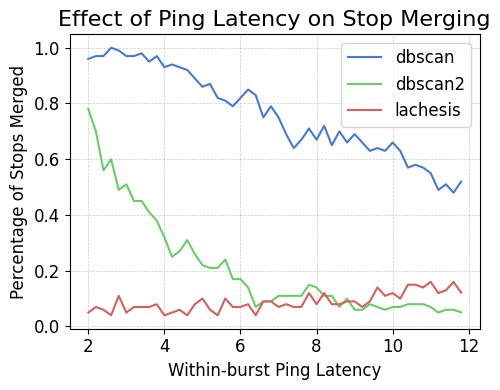

In [20]:
local_metrics_avg = local_metrics.groupby(['beta_ping', 'algorithm'])['merged'].mean().reset_index()
pivoted = local_metrics_avg.pivot(index='beta_ping', columns='algorithm', values='merged')

ax = pivoted.plot(
    kind='line',
    figsize=(5, 4)
)

ax.set_title('Effect of Ping Latency on Stop Merging', fontsize=16)
ax.set_xlabel('Within-burst Ping Latency', fontsize=12)
ax.set_ylabel('Percentage of Stops Merged', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
#plt.savefig("merging.png")

plt.show()

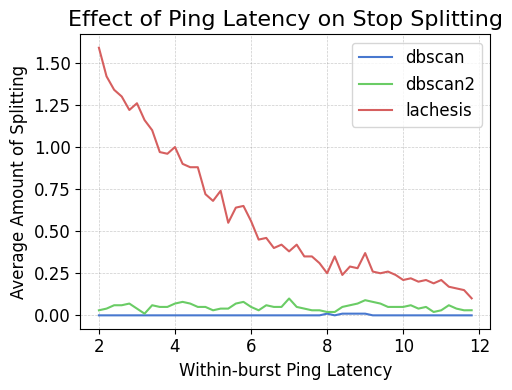

In [21]:
local_metrics_avg = local_metrics.groupby(['beta_ping', 'algorithm'])['split'].mean().reset_index()
pivoted = local_metrics_avg.pivot(index='beta_ping', columns='algorithm', values='split')

ax = pivoted.plot(
    kind='line',
    figsize=(5, 4)
)

ax.set_title('Effect of Ping Latency on Stop Splitting', fontsize=16)
ax.set_xlabel('Within-burst Ping Latency', fontsize=12)
ax.set_ylabel('Average Amount of Splitting', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
#plt.savefig("splitting.png")

plt.show()

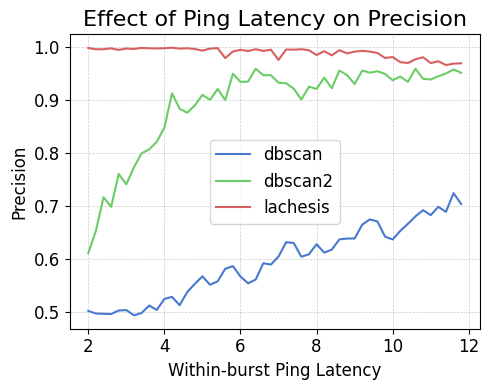

In [22]:
local_metrics_avg = local_metrics.groupby(['beta_ping', 'algorithm'])['precision'].mean().reset_index()
pivoted = local_metrics_avg.pivot(index='beta_ping', columns='algorithm', values='precision')

ax = pivoted.plot(
    kind='line',
    figsize=(5, 4)
)

ax.set_title('Effect of Ping Latency on Precision', fontsize=16)
ax.set_xlabel('Within-burst Ping Latency', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
#plt.savefig("precision.png")

plt.show()

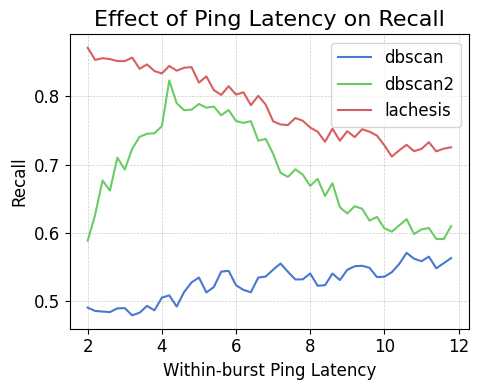

In [23]:
local_metrics_avg = local_metrics.groupby(['beta_ping', 'algorithm'])['recall'].mean().reset_index()
pivoted = local_metrics_avg.pivot(index='beta_ping', columns='algorithm', values='recall')

ax = pivoted.plot(
    kind='line',
    figsize=(5, 4)
)

ax.set_title('Effect of Ping Latency on Recall', fontsize=16)
ax.set_xlabel('Within-burst Ping Latency', fontsize=12)
ax.set_ylabel('Recall', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
#plt.savefig("recall.png")

plt.show()

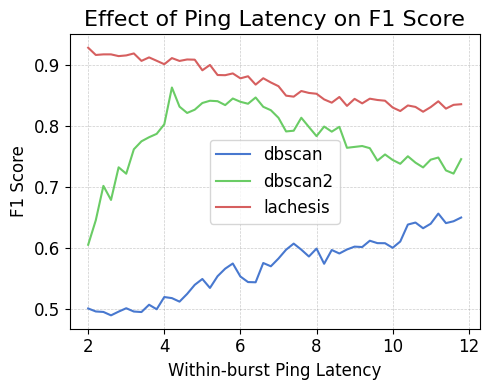

In [24]:
local_metrics_avg = local_metrics.groupby(['beta_ping', 'algorithm'])['f1_score'].mean().reset_index()
pivoted = local_metrics_avg.pivot(index='beta_ping', columns='algorithm', values='f1_score')

ax = pivoted.plot(
    kind='line',
    figsize=(5, 4)
)

ax.set_title('Effect of Ping Latency on F1 Score', fontsize=16)
ax.set_xlabel('Within-burst Ping Latency', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
#plt.savefig("f1.png")

plt.show()

### EPR-generated diaries

In [ ]:
beta_start = 20
beta_dur = 500
beta_ping = np.arange(2, 12, 0.2)

dbscan_params = [(120, 0.5, 2)] # [(120, 0.5, 2), (120, 1, 3)]   # first param (time eps) does not matter for this experiment
lachesis_params = [(5, 120, 2)] # [(5, 120, 2), (5, 120, 1.5)] #dur_min, dt_max, and delta_roam

N = 100
total_tasks = N*len(beta_ping)

In [ ]:
%%time

# Run with parallelization

def process_bp(bp, seed, dbscan_params, beta_start, beta_dur, city, destination, shared_metrics):
    first_timestamp = datetime(2024, 6, 1, hour=1, minute=0)
    while first_timestamp > datetime(2024, 6, 1, hour=0, minute=10):
        seed += N
        # Reset agent
        Charlie = Agent(
            identifier="Charlie",
            home='h-x13-y12',
            workplace='w-x15-y9',
            city=city,
            destination_diary=destination,
            start_time=datetime(2024, 6, 1, hour=0, minute=0),
            dt=0.5
        )
        # Simulate trajectory and sparsify
        population.generate_trajectory(Charlie, seed=seed)
        Charlie.sample_traj_hier_nhpp(beta_start, beta_dur, bp, seed=seed, ha=3/4)
        first_timestamp = Charlie.sparse_traj['local_timestamp'].iloc[0]

    # Run DBScan
    for j, dbscan_param in enumerate(dbscan_params):
        dbscan_out = sd._temporal_dbscan_labels(Charlie.sparse_traj, *dbscan_param, traj_cols)
        stop_table = sd.temporal_dbscan(Charlie.sparse_traj, *dbscan_param, traj_cols, complete_output=False)
        stop_table = identify_stop(dbscan_out, Charlie.sparse_traj, stop_table, city, method='mode')
        _, metrics = cluster_metrics(stop_table, Charlie)
        merged = bool(metrics['Stops Merged'] == 1)
        split = metrics['Split']
        recall = metrics['Recall']
        precision = metrics['Precision']
        # save metrics
        shared_metrics.append([float(bp), seed, ['dbscan', 'dbscan2'][j], merged, split, recall, precision])
    # Run Lachesis
    for j, lachesis_param in enumerate(lachesis_params):
        lachesis_out = sd._lachesis_labels(Charlie.sparse_traj, *lachesis_param, traj_cols)
        stop_table = sd.lachesis(Charlie.sparse_traj, *lachesis_param, traj_cols, complete_output=False)
        stop_table = identify_stop(lachesis_out, Charlie.sparse_traj, stop_table, city, method='mode')
        _, metrics = cluster_metrics(stop_table, Charlie)
        merged = bool(metrics['Stops Merged'] == 1)
        split = metrics['Split']
        recall = metrics['Recall']
        precision = metrics['Precision']
        # save metrics
        shared_metrics.append([float(bp), seed, ['lachesis', 'lachesis2'][j], merged, split, recall, precision])

def parallelize_work(beta_ping, N, dbscan_params, beta_start, beta_dur, city, destination):
    with multiprocessing.Manager() as manager:
        shared_metrics = manager.list()

        # Using ProcessPoolExecutor for parallelism
        with ProcessPoolExecutor() as executor:
            tasks = [
                executor.submit(
                    process_bp,
                    bp,
                    seed,
                    dbscan_params,
                    beta_start,
                    beta_dur,
                    city,
                    destination,
                    shared_metrics
                )
                for bp in beta_ping
                for seed in range(N)
            ]
            
            with tqdm(total=total_tasks, desc="Processing tasks") as pbar:
                for future in concurrent.futures.as_completed(tasks):
                    try:
                        future.result()
                        pbar.update(1)
                    except Exception as e:
                        print(f"Task failed with exception: {e}")
                        pbar.update(1)

        return list(shared_metrics)

local_metrics = parallelize_work(beta_ping, N, dbscan_params, beta_start, beta_dur, city, destination)
local_metrics = pd.DataFrame(list(local_metrics), columns=['beta_ping', 'seed', 'algorithm', 'merged', 'split', 'recall', 'precision'])

In [ ]:
seed=20000
beta_ping=2.0
sd_param=(5, 120, 1.2)

Charlie = Agent(identifier="Charlie",
        home='h-x13-y12',
        workplace='w-x15-y9',
        city=city,
        destination_diary=destination,
        start_time=datetime(2024, 6, 1, hour=0, minute=0),
        dt=0.5)
# simulate trajectory and sparsify
population.generate_trajectory(Charlie, seed=seed)
Charlie.sample_traj_hier_nhpp(beta_start, beta_dur, beta_ping, seed=seed)

sd_out = sd._lachesis_labels(Charlie.sparse_traj, *sd_param, traj_cols)
sd_out.index = sd_out.index.map(lambda x: int(x.timestamp()))

fig, ax = plt.subplots(figsize=(9, 5))

num_clusters = sum(sd_out.cluster.unique() > -1)
for cid in range(num_clusters):
    cpings = sd_out[sd_out.cluster == cid]
    cdata = Charlie.sparse_traj.loc[cpings.index]
    col = cm.tab20c(cid/(num_clusters+1))
    ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=2)

ax.scatter(x=Charlie.sparse_traj.x, 
           y=Charlie.sparse_traj.y, 
           s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=False, zorder=1)

ax.plot(Charlie.sparse_traj.x,
        Charlie.sparse_traj.y,
        linewidth=1, color='blue', alpha=0.2)

ax.set_xlim(12, 17)
ax.set_ylim(8, 13)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

stop_table = sd.generate_stop_table(Charlie.sparse_traj, sd_out)
print(check_merge(Charlie, sd_out, stop_table))
stop_table = identify_stop(sd_out, Charlie.sparse_traj, stop_table, city)
_, metrics, _=cluster_metrics(stop_table, Charlie)
metrics

## need to check everything below

## Bar charts from diaries, type vs fraction_time

In [ ]:
output_type = []
output_size = []
output_truehome = []
for agent_id, agent in population_n.roster.items():
    d = agent.diary.dropna()
    d['id'] = agent_id
    d['type'] = d['location'].apply(lambda b: city.buildings[b].building_type)
    d['size'] = d['location'].apply(lambda b: len(city.buildings[b].blocks) if b in city.buildings else None)
    d['true_home'] = d.apply(lambda x: agent.home == x.location, axis=1)
    bin_edges = [0, 1, 4, 100]
    bin_labels = ['small', 'medium', 'large']
    d['size'] = pd.cut(d['size'], bins=bin_edges, labels=bin_labels, include_lowest=True)

    d_type_agg = d.groupby(['id', 'type'], observed=False).duration.sum().reset_index()
    d_size_agg = d.groupby(['id', 'size'], observed=False).duration.sum().reset_index()
    d_truehome_agg = d.groupby(['id', 'true_home'], observed=False).duration.sum().reset_index()
    output_type += [d_type_agg]
    output_size += [d_size_agg]
    output_truehome += [d_truehome_agg]

bars_type_gc = pd.concat(output_type)
temp = bars_type_gc.groupby('id')['duration'].transform('sum')
bars_type_gc['duration'] = bars_type_gc['duration'] / temp

bars_size_gc = pd.concat(output_size)
temp = bars_size_gc.groupby('id')['duration'].transform('sum')
bars_size_gc['duration'] = bars_size_gc['duration'] / temp

bars_trhome_gc = pd.concat(output_truehome)
temp = bars_trhome_gc.groupby('id')['duration'].transform('sum')
bars_trhome_gc['duration'] = bars_trhome_gc['duration'] / temp

all_stop_tables['type'] = all_stop_tables['location'].apply(
    lambda b: city.buildings[b].building_type if b in city.buildings else None)

all_stop_tables['true_home'] = all_stop_tables.apply(
    lambda x: population_n.roster[x.id].home == x.location, axis=1)

all_stop_tables['size'] = all_stop_tables['location'].apply(
    lambda b: len(city.buildings[b].blocks) if b in city.buildings else None)
bin_edges = [0, 1, 4, 100]
bin_labels = ['small', 'medium', 'large']
all_stop_tables['size'] = pd.cut(all_stop_tables['size'], bins=bin_edges, labels=bin_labels, include_lowest=True)

bars_type = all_stop_tables.groupby(['id', 'dbscan', 'sparsity', 'type'], observed=False).duration.sum().reset_index()
temp = bars_type.groupby(['id', 'dbscan', 'sparsity'])['duration'].transform('sum')
bars_type['duration'] = bars_type['duration'] / temp

bars_size = all_stop_tables.groupby(['id', 'dbscan', 'sparsity', 'size'], observed=False).duration.sum().reset_index()
temp = bars_size.groupby(['id', 'dbscan', 'sparsity'])['duration'].transform('sum')
bars_size['duration'] = bars_size['duration'] / temp

bars_trhome = all_stop_tables.groupby(['id', 'dbscan', 'sparsity', 'true_home'], observed=False).duration.sum().reset_index()
temp = bars_trhome.groupby(['id', 'dbscan', 'sparsity'])['duration'].transform('sum')
bars_trhome['duration'] = bars_trhome['duration'] / temp

# Ensure all combinations of 'id', 'dbscan', 'sparsity', and 'type' are present
unique_ids = bars_type['id'].unique()
unique_dbscan = bars_type['dbscan'].unique()
unique_sparsity = bars_type['sparsity'].unique()
unique_types = bars_type['type'].unique()
all_combinations = pd.DataFrame(list(product(unique_ids, unique_dbscan, unique_sparsity, unique_types)),
                                columns=['id', 'dbscan', 'sparsity', 'type'])
bars_type = all_combinations.merge(bars_type, on=['id', 'dbscan', 'sparsity', 'type'], how='left')
bars_type['duration'] = bars_type['duration'].fillna(0)

bars_rog = all_stop_tables.groupby(['id', 'dbscan', 'sparsity']).agg(
    rog_d=('rog_d', 'mean'),
    rog_sd=('rog_sd', 'mean')
).reset_index()

In [ ]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
bar_width = 0.2
index = np.arange(len(sparsity_levels))

grouped_gc = bars_trhome_gc.groupby('true_home')['duration']
mean_duration_gc = grouped_gc.mean()[True]
std_duration_gc = grouped_gc.std()[True]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

ax.bar(index, mean_duration_gc, bar_width, yerr=std_duration_gc, capsize=5, label='Ground Truth', color=colors[0])

for j, dbscan_param in enumerate(dbscan_options):
    df_sparsity = bars_trhome[bars_trhome['dbscan'] == dbscan_param]

    mean_duration = df_sparsity.groupby('sparsity')['duration'].mean()
    std_duration = df_sparsity.groupby('sparsity')['duration'].std()

    mean_duration = mean_duration.sort_index(ascending=False)
    std_duration = std_duration.sort_index(ascending=False)

    bar_positions = index + (j + 1) * bar_width
    ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
           capsize=5, label=labels[j + 1], color=colors[j + 1])
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])

ax.set_title('True Home')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(labelsx, rotation=0)

In [ ]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
bar_width = 0.2
index = np.arange(len(sparsity_levels))

mean_gc = bars_rog['rog_d'].mean()
std_gc = bars_rog['rog_d'].std()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

ax.bar(index, mean_gc, bar_width, yerr=std_gc, capsize=5, label='Ground Truth', color=colors[0])

for j, dbscan_param in enumerate(dbscan_options):
    df_sparsity = bars_rog[bars_rog['dbscan'] == dbscan_param]

    mean_duration = df_sparsity.groupby('sparsity')['rog_sd'].mean()
    std_duration = df_sparsity.groupby('sparsity')['rog_sd'].std()

    mean_duration = mean_duration.sort_index(ascending=False)
    std_duration = std_duration.sort_index(ascending=False)

    bar_positions = index + (j + 1) * bar_width
    ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
           capsize=5, label=labels[j + 1], color=colors[j + 1])
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])

ax.set_title('Radius of Gyration')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(labelsx, rotation=0)

In [ ]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
building_types = bars_type_gc['type'].unique()

grouped_gc = bars_type_gc.groupby('type')['duration']
mean_duration_gc = grouped_gc.mean()
std_duration_gc = grouped_gc.std()

bar_width = 0.2
index = np.arange(len(sparsity_levels))

fig, axes = plt.subplots(2, 2, figsize=(9, 6))
axes = axes.flatten()

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

for k, building_type in enumerate(building_types):
    ax = axes[k]

    mean_gc = mean_duration_gc[building_type]
    std_gc = std_duration_gc[building_type]
    ax.bar(index, mean_gc, bar_width, yerr=std_gc, capsize=5, label='Ground Truth', color=colors[0])

    for j, dbscan_param in enumerate(dbscan_options):
        df_sparsity = bars_type[bars_type['dbscan'] == dbscan_param]
        df_sparsity = df_sparsity[df_sparsity['type'] == building_type]

        mean_duration = df_sparsity.groupby('sparsity')['duration'].mean()
        std_duration = df_sparsity.groupby('sparsity')['duration'].std()

        mean_duration = mean_duration.sort_index(ascending=False)
        std_duration = std_duration.sort_index(ascending=False)

        bar_positions = index + (j + 1) * bar_width
        ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
               capsize=5, label=labels[j + 1], color=colors[j + 1])

    ax.set_title(f'{building_type.capitalize()}', fontsize=16)
    ax.set_ylabel('Duration (%)', fontsize=14)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(labelsx, rotation=0, fontsize=14)
    ax.set_ylim(0,)
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=14)

plt.savefig('bar_charts.svg')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
building_sizes = bars_size_gc['size'].unique()

grouped_gc = bars_size_gc.groupby('size', observed=False)['duration']
mean_duration_gc = grouped_gc.mean()
std_duration_gc = grouped_gc.std()

bar_width = 0.2
index = np.arange(len(sparsity_levels))

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes = axes.flatten()

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

for k, building_size in enumerate(building_sizes):
    ax = axes[k]

    mean_gc = mean_duration_gc[building_size]
    std_gc = std_duration_gc[building_size]
    ax.bar(index, mean_gc, bar_width, yerr=std_gc, capsize=5, label='Ground Truth', color=colors[0])

    for j, dbscan_param in enumerate(dbscan_options):
        df_sparsity = bars_size[bars_size['dbscan'] == dbscan_param]
        df_sparsity = df_sparsity[df_sparsity['size'] == building_size]

        mean_duration = df_sparsity.groupby('sparsity')['duration'].mean()
        std_duration = df_sparsity.groupby('sparsity')['duration'].std()

        mean_duration = mean_duration.sort_index(ascending=False)
        std_duration = std_duration.sort_index(ascending=False)

        bar_positions = index + (j + 1) * bar_width
        ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
               capsize=5, label=labels[j + 1], color=colors[j + 1])

    ax.set_title(f'{building_size.capitalize()} Buildings', fontsize=16)
    ax.set_ylabel('Duration (%)', fontsize=14)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(labelsx, rotation=0, fontsize=14)
    ax.set_ylim(0,)
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.savefig('bar_size.svg')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Curves

### Fix frequency (q). Vary sparsity pattern by changing first two params.

In [ ]:
%%time

def process_seed(seed, nhpp_params, dbscan_params, lachesis_params, city):
    results_dbscan = []
    results_lachesis = []
    
    Bethany = Agent('Bethany',
                    'h-x13-y9',
                    'w-x3-y13',
                    city,
                    start_time=datetime(2024, 1, 1, hour=0, minute=0))

    population.add_agent(Bethany, verbose=False)
    population.generate_trajectory(Bethany, T=datetime(2024, 1, 15, hour=0, minute=0), seed=seed)

    for nhpp_param in nhpp_params: 
        Bethany.sample_traj_hier_nhpp(*nhpp_param, seed=seed)
        qstat = q_stat(Bethany)

        for k in range(len(dbscan_params)):
            dbscan_param = dbscan_params[k]
            lachesis_param = lachesis_params[k]

            dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_param)
            lachesis_out = sd.lachesis_patches(Bethany.sparse_traj, *lachesis_param)

            stop_table_dbscan = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)
            stop_table_lachesis = sd.generate_stop_table(Bethany.sparse_traj, lachesis_out)

            result_dbscan = {
                'seed': seed,
                'alg_param': ['coarse', 'fine'][k],
                'beta_dur': nhpp_param[1],
                'q': qstat,
                'recall': 0,
                'precision': 0,
                'stop_merging': None,
                'trip_merging': None,
                'missed': 0,
                'split': None,
                'rog_diary': 0,
                'rog_alg': 0
            }

            result_lachesis = result_dbscan.copy()

            if stop_table_dbscan.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)
                result_dbscan.update({
                    'recall': 0,
                    'precision': None,
                    'stop_merging': None,
                    'trip_merging': None,
                    'missed': n_stops,
                    'split': None,
                    'rog_diary': radius_of_gyration(prepared_diary[['x', 'y']]),
                    'rog_alg': 0
                })
            else:
                stop_table_dbscan = identify_stop(dbscan_out, Bethany.sparse_traj, stop_table_dbscan)
                # stop_table_dbscan['location'] = stop_table_dbscan.apply(
                #     lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
                _, metrics, rog = cluster_metrics(stop_table_dbscan, Bethany)
                result_dbscan.update({
                    'recall': metrics['Recall'],
                    'precision': metrics['Precision'],
                    'stop_merging': metrics['Stops Merged'],#/metrics['Stop Count'],
                    'trip_merging': metrics['Trip Merging'],
                    'missed': metrics['Missed'],#/metrics['Stop Count'],
                    'split': metrics['Split'],#/metrics['Stop Count'],
                    'rog_diary': rog['diary'],
                    'rog_alg': rog['stop_table']
                })

            if stop_table_lachesis.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)
                result_lachesis.update({
                    'recall': 0,
                    'precision': None,
                    'stop_merging': None,
                    'trip_merging': None,
                    'missed': n_stops,
                    'split': None,
                    'rog_diary': radius_of_gyration(prepared_diary[['x', 'y']]),
                    'rog_alg': 0
                })
            else:
                stop_table_lachesis = identify_stop(lachesis_out, Bethany.sparse_traj, stop_table_lachesis)
                # stop_table_lachesis['location'] = stop_table_lachesis.apply(
                #     lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
                _, metrics, rog = cluster_metrics(stop_table_lachesis, Bethany)
                result_lachesis.update({
                    'recall': metrics['Recall'],
                    'precision': metrics['Precision'],
                    'stop_merging': metrics['Stops Merged'],#/metrics['Stop Count'],
                    'trip_merging': metrics['Trip Merging'],
                    'missed': metrics['Missed'],#/metrics['Stop Count'],
                    'split': metrics['Split'],#/metrics['Stop Count'],
                    'rog_diary': rog['diary'],
                    'rog_alg': rog['stop_table']
                })

                results_dbscan.append(result_dbscan)
                results_lachesis.append(result_lachesis)

    return pd.DataFrame(results_dbscan), pd.DataFrame(results_lachesis)


seeds = range(1, 175)
dbscan_params = [(360, 5, 2), (60, 1.5, 3)]
lachesis_params = [(10, 480, 6), (10, 60, 1.5)]
beta_starts = range(120, 1600, 40)
beta_durs = range(30, 400, 10)
beta_ping = 10

nhpp_params = [(start, dur, beta_ping) for start, dur in zip(beta_starts, beta_durs)]

with ProcessPoolExecutor() as executor:
    work = partial(process_seed, nhpp_params=nhpp_params,
                   dbscan_params=dbscan_params, lachesis_params=lachesis_params,
                   city=city)
    all_results = list(executor.map(work, seeds))

results_dbscan = [result[0] for result in all_results]
results_lachesis = [result[1] for result in all_results]

results_dbscan = pd.concat(results_dbscan, ignore_index=True)
results_lachesis = pd.concat(results_lachesis, ignore_index=True)

results_dbscan.to_pickle('results-sparsity-dbscan-nofilter-1.pkl')
results_lachesis.to_pickle('results-sparsity-lachesis-nofilter-1.pkl')

In [ ]:
import pickle

with open('results-sparsity-dbscan-nofilter.pkl', 'rb') as file:
    results_dbscan = pickle.load(file)

with open('results-sparsity-lachesis-nofilter.pkl', 'rb') as file:
    results_lachesis = pickle.load(file)

In [ ]:
# Create bins for q, size 0.05 from 0 to 1
# bins = np.arange(0, 1.05, 0.05)
# labels = [i/100+0.025 for i in range(0, 100, 5)]
# results_dbscan['q_bin'] = pd.cut(results_dbscan['q'], bins=bins, labels=labels, include_lowest=True)
# results_lachesis['q_bin'] = pd.cut(results_lachesis['q'], bins=bins, labels=labels, include_lowest=True)

results_dbscan_sparsity = results_dbscan.groupby(['beta_dur', 'alg_param'], observed=True).mean().reset_index()
counts = results_dbscan.groupby(['beta_dur', 'alg_param'], observed=True).size().reset_index(name='count')
results_dbscan_sparsity = results_dbscan_sparsity.merge(counts, on=['beta_dur', 'alg_param'])
results_dbscan_sparsity = results_dbscan_sparsity[results_dbscan_sparsity['count'] >= 10]

results_lachesis_sparsity = results_lachesis.groupby(['beta_dur', 'alg_param'], observed=True).mean().reset_index()
counts = results_lachesis.groupby(['beta_dur', 'alg_param'], observed=True).size().reset_index(name='count')
results_lachesis_sparsity = results_lachesis_sparsity.merge(counts, on=['beta_dur', 'alg_param'])
results_lachesis_sparsity = results_lachesis_sparsity[results_lachesis_sparsity['count'] >= 10]

In [ ]:
results_dbscan_sparsity
#results_lachesis_sparsity

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 1.5))

for i, p in enumerate([2,4,5]):
    ax = axes[i]
    for j in range(2):
        setting = ['coarse', 'fine'][j]
        results_df = results_dbscan_sparsity[results_dbscan_sparsity['alg_param']==setting]
        ax.plot(results_df['beta_dur'], results_df.iloc[:, p+4],
                label=['Coarse', 'Fine'][j],
                color=['red', 'darkgreen'][j],
                linestyle=['-', ':'][j])
        ax.set_title(['Stop Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')
        ax.set_xlabel('Expected Burst Durations')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=3, bbox_to_anchor=(0.51, -0.55))
plt.subplots_adjust(hspace=0.8, wspace=0.2)

plt.savefig("metrics_vs_sparsity-dbscan.png")
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 4))

for i in range(6):
    ax = axes[i % 2, i//2]
    for j in range(2):
        setting = ['coarse', 'fine'][j]
        results_df = results_lachesis_sparsity[results_lachesis_sparsity['alg_param']==setting]
        ax.plot(results_df['beta_dur'], results_df.iloc[:, i+4],
                label=['Coarse', 'Fine'][j],
                color=['black', 'red'][j],
                linestyle=['-', ':'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Trip Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')
        ax.set_xlabel('Expected Burst Durations')

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=3, bbox_to_anchor=(0.51, -0.15))
plt.subplots_adjust(hspace=0.8, wspace=0.2)

plt.savefig("metrics_vs_sparsity-lachesis.png")
plt.show()

### Fix sparsity. Vary DBSCAN parameters.

In [ ]:
seeds = range(100, 150)
hier_nhpp_params = [(90, 30, 4), (60, 60, 2)]  # 3pph, 12pph

# dbscan_params = (time_thresh, dist_thresh, min_pts)
dist_threshs = np.arange(5/15, 200/15, 0.25)

results = np.zeros((len(seeds), len(hier_nhpp_params), len(dist_threshs), 8))

for i, seed in enumerate(seeds):
    Bethany = Agent('Bethany',
                    'h-x13-y9',
                    'w-x3-y13',
                    city,
                    destination_diary=destination)
    population.add_agent(Bethany, verbose=False)
    population.generate_trajectory(Bethany, seed=seed, dt=1)

    for j, hier_nhpp_param in enumerate(hier_nhpp_params):
        Bethany.sample_traj_hier_nhpp(*hier_nhpp_param, seed=seed)
        truepph = round(len(Bethany.sparse_traj) * 2 / 9) / 2
        print(truepph)

        for k, dist_thresh in enumerate(dist_threshs):
            dbscan_param = (240, dist_thresh, 2)
            dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_param)
            stop_table = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)

            if stop_table.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)

                results[i, j, k, 0] = dist_thresh
                results[i, j, k, 1] = 0  # Recall
                results[i, j, k, 2] = 0  # Precision
                results[i, j, k, 3] = None  # Weighted Stop Merging
                results[i, j, k, 4] = None  # Trip Merging
                results[i, j, k, 5] = n_stops  # Stops missed
                results[i, j, k, 6] = None  # Stops split
                results[i, j, k, 7] = q_stat(Bethany)  # q
                continue

            stop_table['location'] = stop_table.apply(
                lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
            metrics_df, metrics = cluster_metrics(stop_table, Bethany)

            results[i, j, k, 0] = dist_thresh
            results[i, j, k, 1] = metrics['Recall']
            results[i, j, k, 2] = metrics['Precision']
            #results[i, j, k, 3] = metrics['Weighted Stop Merging']
            results[i, j, k, 3] = metrics['Stops Merged']
            results[i, j, k, 4] = metrics['Trip Merging']
            results[i, j, k, 5] = metrics['Missed']
            results[i, j, k, 6] = metrics['Split']
            results[i, j, k, 7] = q_stat(Bethany)

    print(seed)

results_param = np.nanmean(results, axis=0)

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(6):
    ax = axes[i//2, i % 2]
    for j in range(2):
        results_df = pd.DataFrame(
            results_param[j, :, :],
            columns=['dist_thresh', 'recall', 'precision', 'weighted_stop_merging', 'trip_merging', 'missed', 'split', 'q_stat'])
        ax.plot(results_df['dist_thresh'], results_df.iloc[:, i+1],
                label=['3pph', '12pph'][j], color=['black', 'red'][j], linestyle=['-', '--'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Trip Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')

#fig.suptitle('Metrics v.s. DBSCAN parameters', fontsize=20)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=2, bbox_to_anchor=(0.5, 0.03))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig("metrics_vs_params.png")
plt.show()